In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import mpl_lego as mplego
import pandas as pd

from hatespeech import keys, utils
from IPython.display import Markdown
from scipy.stats import bootstrap, kruskal

%matplotlib inline

In [2]:
mplego.style.use_latex_style()

In [3]:
exp = "08"
base_path = os.path.join(os.environ['HOME'], 'projects/hatespeech-2021-fairml')
data_path = os.path.join(os.environ['HOME'], 'data/hatespeech/clean_qualtrics_irt_rollout.feather')
rater_quality_path = "~/data/hatespeech/rater_quality_check.csv"
results_path = os.path.join(base_path, f'scaling/experiments/exp{exp}')
out_path = os.path.join(results_path, f"exp{exp}_out.txt")

In [4]:
with open(out_path) as f:
    lines = f.readlines()

In [5]:
bias_lines = lines[26223:26287]

In [6]:
races = {
    'asian': 3,
    'black': 1,
    'latinx': 2,
    'middleeastern': 4,
    'nativeamerican': 5,
    'pacificislander': 6,
    'white': 0,
    'other': 7
}
sorted_races = list(np.array(list(races.keys()))[np.argsort(list(races.values()))])

In [7]:
n_samples = len(bias_lines)
observed = np.zeros(n_samples)
expected = np.zeros(n_samples)
bias_size = np.zeros(n_samples)
std_error = np.zeros(n_samples)
t_stats = np.zeros(n_samples)
p_vals = np.zeros(n_samples)
target = np.zeros(n_samples, dtype=str)
annotator = np.zeros(n_samples, dtype=str)
biases = np.zeros((8, 8))
std_errors = np.zeros((8, 8))
p_values = np.zeros((8, 8))

for idx, line in enumerate(bias_lines):
    processed = line.replace('|', ' ').replace('>', ' ').replace('<', ' ').split()
    observed[idx] = float(processed[0])
    expected[idx] = float(processed[1])
    bias_size[idx] = float(processed[4])
    std_error[idx] = float(processed[5])
    t_stats[idx] = float(processed[6])
    p_vals[idx] = float(processed[8])
    target[idx] = processed[13]
    annotator[idx] = processed[16]

    ii = races[line[88:105].replace(' ', '')]
    jj = races[line[112:132].replace(' ', '')]
    biases[ii, jj] = float(processed[4])
    std_errors[ii, jj] = float(processed[5])
    p_values[ii, jj] = float(processed[8])

In [59]:
lines[26221]

'|  Score   Score    Count  Average|  Size   S.E.     t   d.f. Prob. | MnSq  MnSq | Sq N TargetRace      measr- N AnnotatorRace   measr- |\n'

In [14]:
log_odds = np.exp(biases)

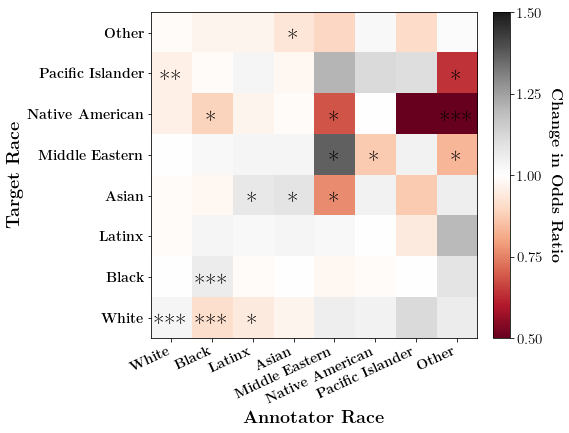

In [76]:
"""
Figure 3
"""
fig_height = 6
fig_width = 6
width = 0.2
spacing = 0.18
axis_label_size = 18
axis_tick_label_size = 14
subplot_label_size = 22
error_capsize = 4

fig, ax = plt.subplots(1, 1, figsize=(fig_height, fig_width))

img = ax.imshow(
    log_odds,
    vmin=0.5,
    vmax=1.5,
    cmap='RdGy',
    origin='lower')
cb, cax = mplego.colorbar.append_colorbar_to_axis(ax, img)
cax.tick_params(labelsize=15)
cax.set_ylim([0.5, 1.5])
cb.set_ticks([0.5, 0.75, 1.0, 1.25, 1.5])
cb.set_label(mplego.labels.bold_text('Change in Odds Ratio'), fontsize=16, rotation=270, labelpad=20)
    
for x in range(8):
    for y in range(8):
        p_val = p_values[x, y]
        color = 'black'
        if p_val < 1e-3:
            ax.text(y, x, s='***',
                    ha='center',
                    va='center',
                    color=color,
                    fontsize=25)
        elif p_val < 1e-2:
            ax.text(y, x, s='**',
                    ha='center',
                    va='center',
                    color=color,
                    fontsize=25)
        elif p_val < 1e-1:
            ax.text(y, x, s='*',
                    ha='center',
                    va='center',
                    color=color,
                    fontsize=25)

ax.set_xticks(np.arange(8))
ax.set_yticks(ax.get_xticks())
ax.set_xticklabels(
    [r'\textbf{White}',
     r'\textbf{Black}',
     r'\textbf{Latinx}',
     r'\textbf{Asian}',
     r'\textbf{Middle Eastern}',
     r'\textbf{Native American}',
     r'\textbf{Pacific Islander}',
     r'\textbf{Other}'],
    ha='right',
    rotation=25,
    fontsize=15)
ax.set_yticklabels(ax.get_xticklabels(), ha='right', rotation=0, fontsize=15)
ax.set_xlabel(mplego.labels.bold_text('Annotator Race'), fontsize=18)
ax.set_ylabel(mplego.labels.bold_text('Target Race'), fontsize=18)
ax.tick_params(labelsize=axis_tick_label_size)
plt.savefig('figureA5.pdf', bbox_inches='tight')

In [67]:
log_odds[0, 1]

0.9139311852712282

In [63]:
log_odds[1, 0]

1.0

In [65]:
p_values[1, 0]

1.0